In [98]:
import tarfile
import netCDF4 as nc
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import itertools
import hydroeval as he


# Directories
pywrdrb_dir = '../../Pywr-DRB/'
path_to_nhm_data = '../../NHM-Data-Retrieval/outputs/hdf'
path_to_nwm_data = '../'

# Comparison dates
start_date = '1983-10-01'
end_date = '2016-12-31'

# Constants
cms_to_mgd = 22.82
cm_to_mg = 264.17/1e6
cfs_to_mgd = 0.64631688969744
crs = 4386

fdc_quantiles = np.linspace(0.0001, 0.99999, 20)

In [128]:
#################
### Load data ###
#################

### USGS 
# Flows: DateTime index with USGS-{station_id} column names
unmanaged_gauge_flows = pd.read_csv('../data/historic_unmanaged_streamflow_1900_2023_cms.csv', sep = ',', 
                                dtype = {'site_no':str}, index_col=0, parse_dates=True)*cms_to_mgd

# Metadata: USGS site number, longitude, latitude, comid, etc.
unmanaged_gauge_meta = pd.read_csv('../data/drb_unmanaged_usgs_metadata.csv', sep = ',', 
                                dtype = {'site_no':str})
unmanaged_gauge_meta.set_index('site_no', inplace=True)

# List of just station numbers
usgs_gauge_ids = [c.split('-')[1] for c in unmanaged_gauge_flows.columns]

### NHMv1.0
# Segment outflows
drb_nhm_segment_flows = pd.read_hdf(f'{path_to_nhm_data}/drb_seg_outflow_mgd.hdf5', key = 'df')
drb_nhm_segment_flows.index = pd.to_datetime(drb_nhm_segment_flows.index)
drb_nhm_segment_flows = drb_nhm_segment_flows.loc['1983-10-01':, :]

# NHM-Gauge matches
# Change column name from nhm_segment_id to comid  ## TODO: Fix this in the NHM-Data-Retrieval code
nhm_gauge_matches = pd.read_csv(f'{path_to_nhm_data}/../drb_nhm_gage_segment_ids.csv', sep = ',', 
                                dtype = {'gage_id':'string', 'nhm_segment_id':'string'})
nhm_gauge_matches['comid'] = nhm_gauge_matches['nhm_segment_id']


### LOO results
Q_pred_nhm = pd.read_csv('../outputs/LOO/loo_reconstruction_nhmv10.csv', index_col=0, parse_dates=True)
loo_sites = Q_pred_nhm.columns

# Make a new DF with gauge meta and statistics of interest
loo_summary = pd.DataFrame(index=loo_sites, columns=['comid', 'long', 'lat'])
for site_number in loo_summary.index:
    loo_summary.loc[site_number, ['comid', 'long', 'lat']] = unmanaged_gauge_meta.loc[site_number, ['comid', 'long', 'lat']]

    # Error stats
    loo_summary.loc[site_number, 'nse_pub'] = he.evaluator(he.nse, Q_pred_nhm.loc[start_date:end_date, site_number], 
                                                       unmanaged_gauge_flows.loc[start_date:end_date, f'USGS-{site_number}'])
    loo_summary.loc[site_number, ['kge_pub', 'r_pub', 'alpha_pub', 'beta_pub']] = he.evaluator(he.kge, Q_pred_nhm.loc[start_date:end_date, site_number], 
                                                                               unmanaged_gauge_flows.loc[start_date:end_date, f'USGS-{site_number}']).flatten()

    nhm_site_flow = drb_nhm_segment_flows.loc[start_date:end_date, nhm_gauge_matches.loc[nhm_gauge_matches['gage_id'] == site_number, 'comid'].values[0]]
    
    loo_summary.loc[site_number, 'nse_nhm'] = he.evaluator(he.nse, nhm_site_flow,
                                                           unmanaged_gauge_flows.loc[start_date:end_date, f'USGS-{site_number}'])
    loo_summary.loc[site_number, ['kge_nhm', 'r_nhm', 'alpha_nhm', 'beta_nhm']] = he.evaluator(he.kge, Q_pred_nhm.loc[start_date:end_date, site_number], 
                                                                               unmanaged_gauge_flows.loc[start_date:end_date, f'USGS-{site_number}']).flatten()

### Spatial
drb_boundary = gpd.read_file(f'{pywrdrb_dir}DRB_spatial/DRB_shapefiles/drb_bnd_polygon.shp').to_crs(crs)
drb_mainstem = gpd.read_file(f'{pywrdrb_dir}DRB_spatial/DRB_shapefiles/delawareriver.shp').to_crs(crs)

In [23]:
### Calculate FDCs
## USGS
unmanaged_gauge_fdcs = pd.DataFrame(index = fdc_quantiles, columns = loo_sites)
for site_number in loo_sites:
    unmanaged_gauge_fdcs[site_number] = unmanaged_gauge_flows[f'USGS-{site_number}'].dropna().quantile(fdc_quantiles)

## NHM
nhm_fdcs = pd.DataFrame(index = fdc_quantiles, columns = loo_sites)
for site_number in loo_sites:
    # Get corresponding NHM COMID
    nhm_comid = nhm_gauge_matches.loc[nhm_gauge_matches['gage_id'] == site_number, 'comid'].values[0]
    nhm_fdcs[site_number] = drb_nhm_segment_flows[nhm_comid].dropna().quantile(fdc_quantiles)


## Differences
# All NHM site matches

# Just LOO sites
fdc_diffs = nhm_fdcs - unmanaged_gauge_fdcs
fdc_percent_diffs = (nhm_fdcs - unmanaged_gauge_fdcs)/unmanaged_gauge_fdcs*100

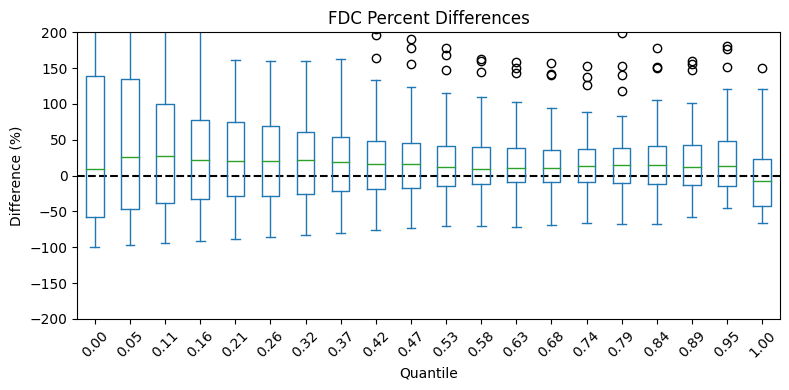

In [54]:
### Plot the distribution of FDC percent differences at each quantile
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.hlines(0, xmin=0.5, xmax=len(fdc_quantiles)+0.5, linestyle='--', color='k')
fdc_percent_diffs.T.plot(kind='box', ax=ax)
ax.set_ylim([-200, 200])
# Reduce tick label to 2 decimal points and rotate xtick labels 
xtick_labels = ax.get_xticklabels()
ax.set_xticklabels([f'{float(x.get_text()):.2f}' for x in xtick_labels], rotation=45)
ax.set_ylabel('Difference (%)')
ax.set_xlabel('Quantile')
ax.set_title('FDC Percent Differences')
plt.tight_layout()



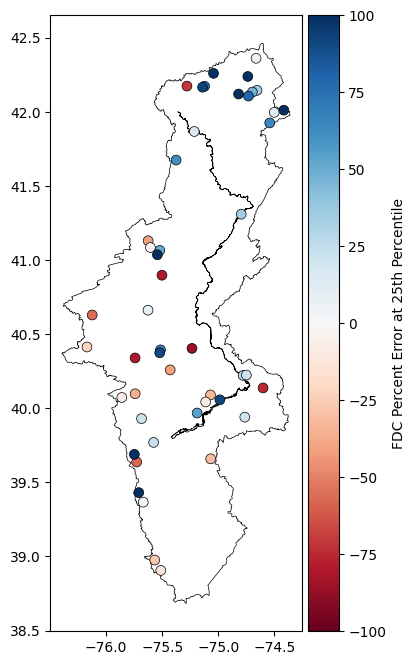

In [134]:
q_i = 5
fdc_label = f'FDC Difference at {fdc_quantiles[q_i]*100:.0f} quantile (%)'

## Plot spatial distribution of differences
fig, ax = plt.subplots(1,1, figsize=(8,8))

# Plot DRB boundary and mainstem
drb_boundary.plot(ax=ax, color='none', edgecolor='k', linewidth=0.5)
drb_mainstem.plot(ax=ax, color='none', edgecolor='k', linewidth=0.5)

# Plot gauge locations with color by FDC difference at specified quantile
unmanaged_gauge_meta['geometry'] = gpd.points_from_xy(unmanaged_gauge_meta['long'], unmanaged_gauge_meta['lat'])

# Set colormap
cmap = mpl.colormaps['RdBu']

# Prep color aligned with gauges
sorted_fdc_perc_diffs = fdc_percent_diffs.loc[:, loo_sites].T

ax.scatter(unmanaged_gauge_meta.loc[loo_sites, 'long'], unmanaged_gauge_meta.loc[loo_sites, 'lat'], 
           c=sorted_fdc_perc_diffs.iloc[:, q_i], vmin=-100, vmax=100, cmap=cmap, s=50, edgecolor='k', linewidth=0.5)

# ax.scatter(loo_summary['long'], loo_summary['lat'],
#            c=loo_summary['nse_pub'], vmin=-1, vmax=1, cmap='viridis', s=50, edgecolor='k', linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(ax.collections[2], ax=ax,
                    label='FDC Percent Error at 25th Percentile', 
                    orientation='vertical', pad=0.01)

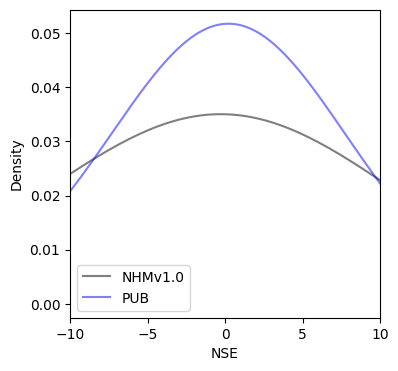

In [137]:
# Plot distribution of NSE
fig,ax =plt.subplots(1,1, figsize=(4,4))
loo_summary['nse_nhm'].plot(kind='kde', ax=ax, color='k', alpha=0.5, xlim=[-10,10], label='NHMv1.0')
loo_summary['nse_pub'].plot(kind='kde', color='blue', alpha=0.5, ax=ax, label ='PUB')
ax.set_xlabel('NSE')
plt.legend()